# Companion Notebook - 7.3 Getting the most out of your models 
## updated for TensorFlow & Keras 2.x
## Chap 7 « Advanced Deep-learning best practices » 
## « Deep Learning with Python » book by François Chollet 

This notebook contains the code samples found in Chapter 7 of «Deep Learning with Python». Note that the original text features far more content, in particular further explanations and figures. In this companion Notebook, you will find source code along with small corrections and some additions by Claude COULOMBE - PhD - Montréal.

In [1]:
# sudo pip3 install --ignore-installed --upgrade tensorflow
import keras
print("Keras version:",keras.__version__)
import tensorflow as tf
print("TensorFlow version:",tf.__version__)


Using TensorFlow backend.


Keras version: 2.3.1
TensorFlow version: 2.2.0


## 7.3. Getting the most out of your models

In this section, we’ll go beyond “works okay” to “works great and wins machine-learning competitions” by offering you a quick guide to a set of must-know techniques for building state-of-the-art deep-learning models. 

### 7.3.1. Advanced architecture patterns 

We covered one important design pattern in detail in the previous section: residual connections. There are two more design patterns you should know about: normalization and depthwise separable convolution. 

#### Normalization

<i>Normalization</i> is a broad category of methods that seek to make different samples seen by a machine-learning model more similar to each other, which helps the model learn and generalize well to new data. The most common form of data normalization is one you’ve seen several times in this book already: centering the data on 0 by subtracting the mean from the data, and giving the data a unit standard deviation by dividing the data by its standard deviation based on the assumption that the data follows a normal (or Gaussian) distribution:

```Python
    normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)
```

#### Batch normalization 

Data normalization should be a concern after every transformation operated by the network: even if the data entering a Dense or Conv2D network has a 0 mean and unit variance, there’s no reason to expect a priori that this will be the case for the data coming out. 

<i>Batch normalization</i> is a type of layer (`BatchNormalization` in Keras) introduced in 2015 by Ioffe and Szegedy that can adaptively normalize data even as the mean and variance change over time during training. It works by internally maintaining an exponential moving average of the batch-wise mean and variance of the data seen during training. The main effect of batch normalization is that it helps with gradient propagation and allows deeper networks. For instance, BatchNormalization is used liberally in many of the advanced convnet architectures that come packaged with Keras, such as ResNet50, Inception V3, and Xception.  

The `BatchNormalization` layer is typically used after a convolutional or densely connected layer:

```Python
    conv_model.add(layers.Conv2D(32, 3, activation='relu'))
    # Batch normalization used after a Conv layer
    conv_model.add(layers.BatchNormalization())

    dense_model.add(layers.Dense(32, activation='relu'))
    # Batch normalization used after a Dense layer
    dense_model.add(layers.BatchNormalization())
```
The `BatchNormalization` layer takes an axis argument, which specifies the feature axis that should be normalized. This argument defaults to -1, the last axis in the input tensor. This is the correct value when using Dense layers, Conv1D layers, RNN layers, and Conv2D layers with data_format set to "channels_last". But in the niche use case of Conv2D layers with data_format set to "channels_first", the features axis is axis 1; the axis argument in BatchNormalization should accordingly be set to 1.

#### Batch renormalization 
A recent improvement over regular batch normalization is batch renormalization, introduced by Ioffe in 2017. It offers clears benefits over batch normalization, at no apparent cost. At the time of writing, it’s too early to tell whether it will supplant batch normalization. Even more recently, Klambauer et al. introduced self-normalizing neural networks,which manage to keep data normalized after going through any Dense layer by using a specific activation function (`selu`) and a specific initializer (`lecun_normal`). This scheme, although highly interesting, is limited to densely connected networks for now, and its usefulness hasn’t yet been broadly replicated.

#### Depthwise separable convolution 
<i>Depthwise separable convolution layer</i> can make a model lighter (fewer trainable weight parameters) and faster (fewer floating-point operations) and cause it to perform a few percentage points better on its task. The For example, SeparableConv2D layer performs a spatial convolution on each channel of its input, independently, before mixing output channels via a pointwise convolution (a 1 × 1 convolution). This is equivalent to separating the learning of spatial features and the learning of channel-wise features. It requires significantly fewer parameters and involves fewer computations, thus resulting in smaller, speedier models. And because it’s a more representationally efficient way to perform convolution, it tends to learn better representations using less data, resulting in better-performing models. 

These advantages become especially important when you’re training small models from scratch on limited data. For instance, here’s how you can build a lightweight, depthwise separable convnet for an image-classification task (softmax categorical classification) on a small dataset:

When it comes to larger-scale models, depthwise separable convolutions are the basis of the Xception architecture, a high-performing convnet that comes packaged with Keras. 

#### Training a Depthwise separable convolution
#####  on the CIFAR10 dataset

The original code above requires an imges dataset in the format 64 height x 64 width x 3 channels. Furthermore, in order to work, depthwise separable convolution needs multichannel data, so MNIST dataset is not appropriate (28x28x1) since that has only one channel. Fortunately, KERAS has the CIFAR10 dataset which is in the format (32x32x3), so 3 channels. 

Therefore, we will adapt a code example from the KERAS GitHub repo: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [2]:
# https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

'''Trains a Depthwise separable convolution on the CIFAR10 dataset.
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_height = 32
img_width = 32
channels = 3

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_height, img_width)
    x_test = x_test.reshape(x_test.shape[0], channels, img_height, img_width)
    input_shape = (channels, img_height, img_width)
else:
    x_train = x_train.reshape(x_train.shape[0], img_height, img_width, channels)
    x_test = x_test.reshape(x_test.shape[0], img_height, img_width, channels)
    input_shape = (img_height, img_width, channels)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_a = Sequential()
model_a.add(layers.SeparableConv2D(32, 3,
                                 activation='relu',
                                 input_shape=(img_height, img_width, channels,))) 
model_a.add(layers.SeparableConv2D(64, 3, activation='relu'))
model_a.add(layers.MaxPooling2D(2))
model_a.add(layers.SeparableConv2D(64, 3, activation='relu'))
model_a.add(layers.SeparableConv2D(128, 3, activation='relu'))
model_a.add(layers.MaxPooling2D(2)) 
model_a.add(layers.SeparableConv2D(64, 3, activation='relu')) 
model_a.add(layers.SeparableConv2D(128, 3, activation='relu')) 
model_a.add(layers.GlobalAveragePooling2D())
model_a.add(layers.Dense(32, activation='relu'))
model_a.add(layers.Dense(num_classes, activation='softmax')) 


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


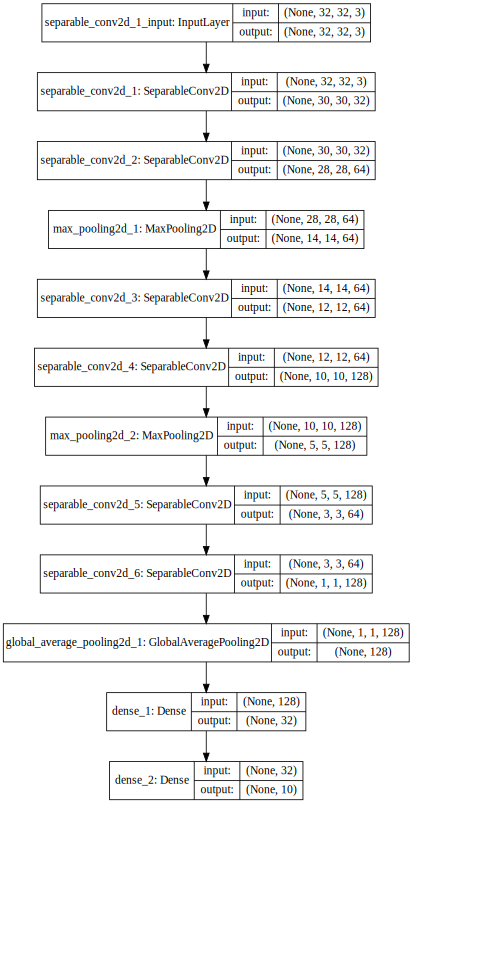

In [3]:
from keras.utils import plot_model 
plot_model(model_a, to_file='model.png')

# https://stackoverflow.com/questions/51452569/how-to-resize-rescale-a-svg-graphic-in-an-ipython-jupyter-notebook/51452570#51452570
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model_a, show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))


In [4]:
model_a.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              # Adding accuracy metrics 
              metrics=['accuracy'])


In [5]:
model_a.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))


Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [==============================] - 254s 5ms/step - loss: 2.3028 - accuracy: 0.0989 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/12
50000/50000 [==============================] - 221s 4ms/step - loss: 2.3027 - accuracy: 0.0978 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/12
50000/50000 [==============================] - 210s 4ms/step - loss: 2.3027 - accuracy: 0.0973 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/12
50000/50000 [==============================] - 206s 4ms/step - loss: 2.3027 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/12
50000/50000 [==============================] - 201s 4ms/step - loss: 2.3027 - accuracy: 0.0966 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/12
50000/50000 [==============================] - 201s 4ms/step - loss: 2.3027 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/12
50000/50000 [==============================] - 201s

In [6]:
score = model_a.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 2.3025950916290285
Test accuracy: 0.10000000149011612


#### Regular Training with a simple ConvNet 
#####  on the CIFAR10 dataset

In [7]:
'''
Trains a simple convnet on the CIFAR10 dataset.
with rmsprop optimizer
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_height = 32
img_width = 32
channels = 3

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_height, img_width)
    x_test = x_test.reshape(x_test.shape[0], channels, img_height, img_width)
    input_shape = (channels, img_height, img_width)
else:
    x_train = x_train.reshape(x_train.shape[0], img_height, img_width, channels)
    x_test = x_test.reshape(x_test.shape[0], img_height, img_width, channels)
    input_shape = (img_height, img_width, channels)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_b = Sequential()
model_b.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_b.add(Conv2D(64, (3, 3), activation='relu'))
model_b.add(MaxPooling2D(pool_size=(2, 2)))
model_b.add(Dropout(0.25))
model_b.add(Flatten())
model_b.add(Dense(128, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(num_classes, activation='softmax'))

model_b.compile(loss='categorical_crossentropy',
              # replace by rmsprop for comparison
              optimizer='rmsprop',
              # Adding accuracy metrics 
              metrics=['accuracy'])

model_b.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [==============================] - 235s 5ms/step - loss: 1.6998 - accuracy: 0.3898 - val_loss: 1.4155 - val_accuracy: 0.5259
Epoch 2/12
50000/50000 [==============================] - 198s 4ms/step - loss: 1.3263 - accuracy: 0.5328 - val_loss: 1.0801 - val_accuracy: 0.6237
Epoch 3/12
50000/50000 [==============================] - 132s 3ms/step - loss: 1.1752 - accuracy: 0.5878 - val_loss: 1.0560 - val_accuracy: 0.6326
Epoch 4/12
50000/50000 [==============================] - 127s 3ms/step - loss: 1.0811 - accuracy: 0.6225 - val_loss: 0.9751 - val_accuracy: 0.6583
Epoch 5/12
50000/50000 [==============================] - 127s 3ms/step - loss: 1.0200 - accuracy: 0.6457 - val_loss: 0.9886 - val_accuracy: 0.6582
Epoch 6/12
50000/50000 [==============================] - 128s 3ms/step - loss: 0.9657 - accuracy: 0.6658 - val_loss: 0.9338 - val_accura

In [8]:
score = model_b.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.985818069267273
Test accuracy: 0.6705999970436096


The results are not very convincing. Depthwise separable convolution gives an accuracy of 55% that is inferior to the 70% of the simple ConvNet model. Probably that the model is not big /deep enough. 

In [9]:
'''
Trains a simple convnet on the CIFAR10 dataset.
with Adadelta optimizer
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_height = 32
img_width = 32
channels = 3

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_height, img_width)
    x_test = x_test.reshape(x_test.shape[0], channels, img_height, img_width)
    input_shape = (channels, img_height, img_width)
else:
    x_train = x_train.reshape(x_train.shape[0], img_height, img_width, channels)
    x_test = x_test.reshape(x_test.shape[0], img_height, img_width, channels)
    input_shape = (img_height, img_width, channels)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_c = Sequential()
model_c.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_c.add(Conv2D(64, (3, 3), activation='relu'))
model_c.add(MaxPooling2D(pool_size=(2, 2)))
model_c.add(Dropout(0.25))
model_c.add(Flatten())
model_c.add(Dense(128, activation='relu'))
model_c.add(Dropout(0.5))
model_c.add(Dense(num_classes, activation='softmax'))

model_c.compile(loss='categorical_crossentropy',
              # The model_c is optimized with the Adadelta optimizer
              optimizer='Adadelta',
              # Adding accuracy metrics 
              metrics=['accuracy'])

model_c.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [==============================] - 133s 3ms/step - loss: 1.7925 - accuracy: 0.3539 - val_loss: 1.3721 - val_accuracy: 0.5182
Epoch 2/12
50000/50000 [==============================] - 131s 3ms/step - loss: 1.3711 - accuracy: 0.5128 - val_loss: 1.1768 - val_accuracy: 0.5819
Epoch 3/12
50000/50000 [==============================] - 130s 3ms/step - loss: 1.1903 - accuracy: 0.5804 - val_loss: 1.1260 - val_accuracy: 0.6163
Epoch 4/12
50000/50000 [==============================] - 132s 3ms/step - loss: 1.0664 - accuracy: 0.6247 - val_loss: 0.9715 - val_accuracy: 0.6576
Epoch 5/12
50000/50000 [==============================] - 129s 3ms/step - loss: 0.9876 - accuracy: 0.6549 - val_loss: 0.9215 - val_accuracy: 0.6790
Epoch 6/12
50000/50000 [==============================] - 129s 3ms/step - loss: 0.9250 - accuracy: 0.6783 - val_loss: 0.9120 - val_accura

In [10]:
score = model_c.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.8615231519699097
Test accuracy: 0.7064999938011169


In [11]:
'''Trains a simple deep NN (MLP: Multi-Layer Perceptron) 
   on the CIFAR10 dataset.
'''
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

batch_size = 128
num_classes = 10
epochs = 20
# epochs = 12

# the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape)
print(x_test.shape)

# x_train = x_train.reshape(60000, 784)
x_train = x_train.reshape(50000, 3072)
# x_test = x_test.reshape(10000, 784)
x_test = x_test.reshape(10000, 3072)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_d = Sequential()
# model_d.add(Dense(512, activation='relu', input_shape=(784,)))
model_d.add(Dense(512, activation='relu', input_shape=(3072,)))
model_d.add(Dropout(0.2))
model_d.add(Dense(512, activation='relu'))
model_d.add(Dropout(0.2))
model_d.add(Dense(num_classes, activation='softmax'))

model_d.summary()


(50000, 32, 32, 3)
(10000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_d.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model_d.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 15s 290us/step - loss: 2.1510 - accuracy: 0.2481 - val_loss: 1.9004 - val_accuracy: 0.2986
Epoch 2/20
50000/50000 [==============================] - 14s 282us/step - loss: 1.8581 - accuracy: 0.3290 - val_loss: 1.8088 - val_accuracy: 0.3489
Epoch 3/20
50000/50000 [==============================] - 15s 293us/step - loss: 1.7757 - accuracy: 0.3607 - val_loss: 1.6859 - val_accuracy: 0.4073
Epoch 4/20
50000/50000 [==============================] - 14s 287us/step - loss: 1.7298 - accuracy: 0.3810 - val_loss: 1.6326 - val_accuracy: 0.4289
Epoch 5/20
50000/50000 [==============================] - 14s 278us/step - loss: 1.6898 - accuracy: 0.3945 - val_loss: 1.6298 - val_accuracy: 0.4160
Epoch 6/20
50000/50000 [==============================] - 14s 290us/step - loss: 1.6643 - accuracy: 0.4069 - val_loss: 1.6093 - val_accuracy: 0.4272
Epoch 7/20
50000/50000 [==============================] 

In [13]:
score = model_d.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 1.527995453453064
Test accuracy: 0.46630001068115234


### 7.3.2. Hyperparameter optimization 

When building a deep-learning model, you have to make many seemingly arbitrary decisions: How many layers should you stack? How many units or filters should go in each layer? Should you use `relu` as activation, or a different function? Should you use `BatchNormalization` after a given layer? How much dropout should you use? And so on. These architecture-level parameters are called <i>hyperparameters</i> to distinguish them from the parameters of a model, which are trained via backpropagation. 

In practice, experienced machine-learning engineers and researchers build intuition over time as to what works and what doesn’t when it comes to these choices—they develop hyperparameter-tuning skills. But there are no formal rules. If you want to get to the very limit of what can be achieved on a given task, you can’t be content with arbitrary choices made by a fallible human. Your initial decisions are almost always suboptimal, even if you have good intuition. You can refine your choices by tweaking them by hand and retraining the model repeatedly—that’s what machine-learning engineers and researchers spend most of their time doing. But it shouldn’t be your job as a human to fiddle with hyperparameters all day—that is better left to a machine. 

Thus you need to explore the space of possible decisions automatically, systematically, in a principled way. You need to search the architecture space and find the best-performing ones empirically. That’s what the field of automatic hyperparameter optimization is about: it’s an entire field of research, and an important one.

The process of optimizing hyperparameters typically looks like this: 

* Choose a set of hyperparameters (automatically).
* Build the corresponding model.
* Fit it to your training data, and measure the final performance on the validation data. 
* Choose the next set of hyperparameters to try (automatically). 
* Repeat. 
* Eventually, measure performance on your test data. 

The key to this process is the algorithm that uses this history of validation performance, given various sets of hyperparameters, to choose the next set of hyperparameters to evaluate. Many different techniques are possible: Bayesian optimization (https://en.wikipedia.org/wiki/Bayesian_optimization), genetic algorithms (https://en.wikipedia.org/wiki/Genetic_algorithm), simple random search (https://en.wikipedia.org/wiki/Random_search), and so on.

The key to this process is the algorithm that uses this history of validation performance, given various sets of hyperparameters, to choose the next set of hyperparameters to evaluate. Many different techniques are possible: Bayesian optimization, genetic algorithms, simple random search, and so on. 

Training the weights of a model is relatively easy: you compute a loss function on a mini-batch of data and then use the Backpropagation algorithm to move the weights in the right direction. Updating hyperparameters, on the other hand, is extremely challenging. Consider the following: 

* Computing the feedback signal (does this set of hyperparameters lead to a high-performing model on this task?) can be extremely expensive: it requires creating and training a new model from scratch on your dataset. 
* The hyperparameter space is typically made of discrete decisions and thus isn’t continuous or differentiable. Hence, you typically can’t do gradient descent in hyperparameter space. Instead, you must rely on gradient-free optimization techniques, which naturally are far less efficient than gradient descent.

Because these challenges are difficult and the field is still young, we currently only have access to very limited tools to optimize models. Often, it turns out that random search (choosing hyperparameters to evaluate at random, repeatedly) is the best solution, despite being the most naive one. But one tool I have found reliably better than random search is Hyperopt (https://github.com/hyperopt/hyperopt), a Python library for hyperparameter optimization that internally uses trees of Parzen estimators to predict sets of hyperparameters that are likely to work well. Another library called Hyperas (https://github.com/maxpumperla/hyperas) integrates Hyperopt for use with Keras models. Do check it out.

** Note ** 
> One important issue to keep in mind when doing automatic hyperparameter optimization at scale is validation-set overfitting. Because you’re updating hyperparameters based on a signal that is computed using your validation data, you’re effectively training them on the validation data, and thus they will quickly overfit to the validation data. Always keep this in mind.

Overall, hyperparameter optimization is a powerful technique that is an absolute requirement to get to state-of-the-art models on any task or to win machine-learning competitions. Think about it: once upon a time, people handcrafted the features that went into shallow machine-learning models. That was very much suboptimal. Now, deep learning automates the task of hierarchical feature engineering—features are learned using a feedback signal, not hand-tuned, and that’s the way it should be. In the same way, you shouldn’t handcraft your model architectures; you should optimize them in a principled way. At the time of writing, the field of automatic hyperparameter optimization is very young and immature, as deep learning was some years ago, but I expect it to boom in the next few years.

### 7.3.3. Model ensembling 
Another powerful technique for obtaining the best possible results on a task is model ensembling. Ensembling consists of pooling together the predictions of a set of different models, to produce better predictions. If you look at machine-learning competitions, in particular on Kaggle, you’ll see that the winners use very large ensembles of models that inevitably beat any single model, no matter how good. 

Ensembling relies on the assumption that different good models trained independently are likely to be good for different reasons: each model looks at slightly different aspects of the data to make its predictions, getting part of the “truth” but not all of it. You may be familiar with the ancient parable of the blind men and the elephant: a group of blind men come across an elephant for the first time and try to understand what the elephant is by touching it. Each man touches a different part of the elephant’s body—just one part, such as the trunk or a leg. Then the men describe to each other what an elephant is: “It’s like a snake,” “Like a pillar or a tree,” and so on. The blind men are essentially machine-learning models trying to understand the manifold of the training data, each from its own perspective, using its own assumptions (provided by the unique architecture of the model and the unique random weight initialization). Each of them gets part of the truth of the data, but not the whole truth. By pooling their perspectives together, you can get a far more accurate description of the data. The elephant is a combination of parts: not any single blind man gets it quite right, but, interviewed together, they can tell a fairly accurate story. 

Let’s use classification as an example. The easiest way to pool the predictions of a set of classifiers (to ensemble the classifiers) is to average their predictions at inference time:

In [14]:
x_test.shape


(10000, 3072)

In [15]:
x_val = x_test.reshape(10000, 32, 32, 3)
# Use four different models to compute initial predictions.
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_test)

# This new prediction array should be more accurate than any of the initial ones.
final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)

import numpy as np
final_preds_one_hot = np.zeros_like(final_preds)
final_preds_one_hot[np.arange(len(final_preds)), final_preds.argmax(1)] = 1

from sklearn.metrics import accuracy_score
accuracy_score(y_test, final_preds_one_hot)


0.7164

This will work only if the classifiers are more or less equally good. If one of them is significantly worse than the others, the final predictions may not be as good as the best classifier of the group. A smarter way to ensemble classifiers is to do a weighted average, where the weights are learned on the validation data—typically, the better classifiers are given a higher weight, and the worse classifiers are given a lower weight. To search for a good set of ensembling weights, you can use random search or a simple optimization algorithm such as Nelder-Mead.

With a homemade one_hot_encoder and accuracy_score from Scikit Learn:

In [16]:
import numpy as np
# These weights (0.2, 0.40, 0.35, 0.05) are assumed to be learned empirically.
final_preds = 0.2 * preds_a + 0.40 * preds_b + 0.35 * preds_c + 0.05 * preds_d 
final_preds_one_hot = np.zeros_like(final_preds)
final_preds_one_hot[np.arange(len(final_preds)), final_preds.argmax(1)] = 1

from sklearn.metrics import accuracy_score
accuracy_score(y_test, final_preds_one_hot)


0.7174

With a Keras one_hot encoder and accuracy_score from Scikit Learn:

In [17]:
from keras import backend as K
final_preds_one_hot = K.one_hot(K.argmax(final_preds,axis=1),10)

from sklearn.metrics import accuracy_score
# accuracy_score(y_test,tf.Session().run(final_preds_one_hot))
accuracy_score(y_test,final_preds_one_hot)


0.7174

There are many possible variants: you can do an average of an exponential of the predictions, for instance. In general, a simple weighted average with weights optimized on the validation data provides a very strong baseline. 

The key to making ensembling work is the <i>diversity</i> of the set of classifiers. Diversity is strength. If your models are <i>biased in different ways</i>, the biases will cancel each other out, and the ensemble will be more robust and more accurate. 

For this reason, you should ensemble models that are <i>as good as possible</i> while being as different as possible. This typically means using very different architectures or even different brands of machine-learning approaches. One thing that is largely not worth doing is ensembling the same network trained several times independently, from different random initializations. If the only difference between your models is their random initialization and the order in which they were exposed to the training data, then your ensemble will be low-diversity and will provide only a tiny improvement over any single model. The point of ensembling. It’s not so much about how good your best model is; it’s about the diversity of your set of candidate models. 

In recent times, one style of basic ensemble that has been very successful in practice is the wide and deep category of models, blending deep learning with shallow learning. Such models consist of jointly training a deep neural network with a large linear model. The joint training of a family of diverse models is yet another option to achieve model ensembling. 

In [18]:
print("IPython Notebook executed")


IPython Notebook executed
